<a href="https://colab.research.google.com/github/ba18406/reassessments/blob/master/Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 1
np.random.seed(RANDOM_STATE_SEED)

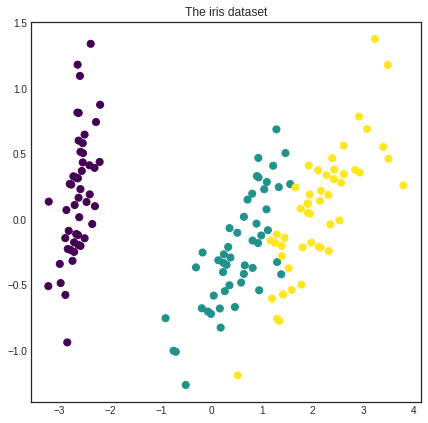

In [2]:
#Loading the iris dataset. Performing principal component analysis on iris dataset. Then visualizing the results of principal component analysis.

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# loading the iris dataset
iris = load_iris()

# visualizing the classes
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    pca = PCA(n_components=2).fit_transform(iris['data'])                   
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=iris['target'], cmap='viridis', s=50)
    plt.title('The iris dataset')
    plt.show()

In [3]:
#Making a pool of predictors and target variables from the original dataset. This is later used by ModAL for active learning.
from copy import deepcopy

# generate the pool
X_pool = deepcopy(iris['data'])
y_pool = deepcopy(iris['target'])

In [4]:
pip install modAL

In [9]:
#The core code for active learning. First we are making a training dataset from the pool of data we created in previous step.
#After that we depleted are pool intentionaly so that we can use this pool now as a test data set.
#Finally we used active learning with Random forest and KNN as its estimator. We trained it on the training data set we created earlier.
#Both of these trained models are finally appended in the list.

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

n_members = 2
learner_list = list()

for member_idx in range(n_members):
    # initial training data
    n_initial = 2
    train_idx = np.random.choice(range(X_pool.shape[0]), size=n_initial, replace=False)
    X_train = X_pool[train_idx]
    y_train = y_pool[train_idx]

    # creating a reduced copy of the data with the known instances removed
    X_pool = np.delete(X_pool, train_idx, axis=0)
    y_pool = np.delete(y_pool, train_idx)

    # initializing learner
    if  (n_members == 0):               #Added this new code here.
      learner = ActiveLearner(estimator=RandomForestClassifier(), X_training=X_train, y_training=y_train)
    else:
      learner = ActiveLearner(estimator=KNeighborsClassifier(n_neighbors=2), X_training=X_train, y_training=y_train)
    learner_list.append(learner)

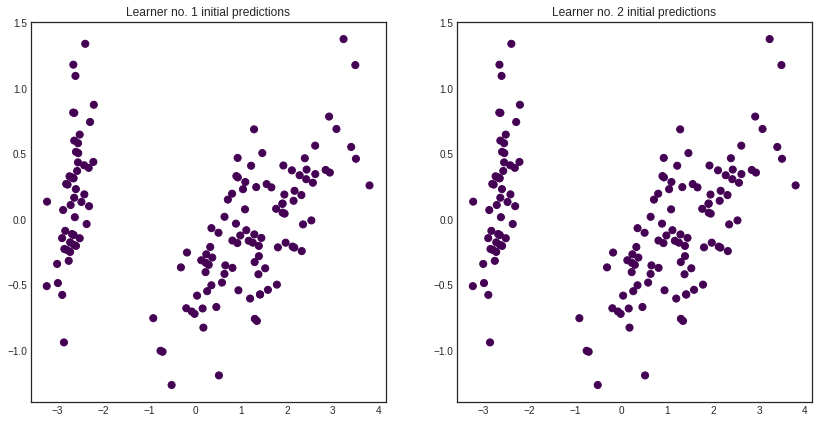

In [10]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(learner_list):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d initial predictions' % (learner_idx + 1))
    plt.show()

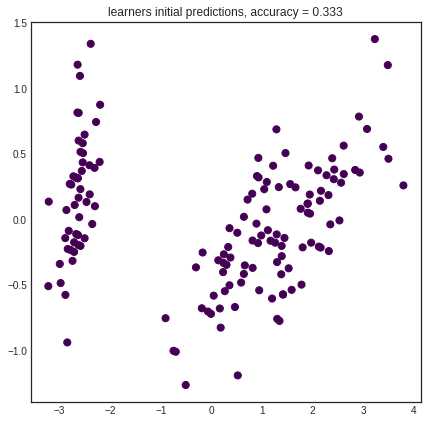

In [11]:
unqueried_score = learner.score(iris['data'], iris['target'])

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = learner.predict(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('learners initial predictions, accuracy = %1.3f' % unqueried_score)
    plt.show()

In [12]:
predictions = learner.predict(X_pool)
is_correct = (predictions == y_pool)

predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

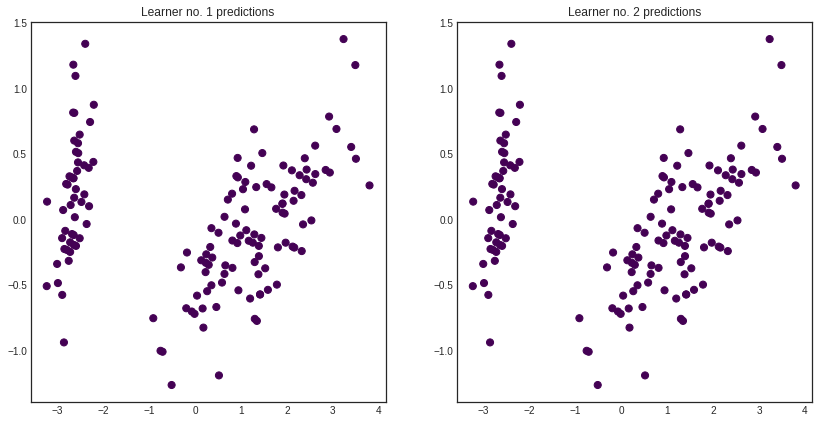

In [13]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(learner_list):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions' % (learner_idx + 1))
    plt.show()

In [14]:
#Cross validation for KNN and Random Forest in active learner.

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
score = cross_val_score(learner_list[0], X_pool, y_pool, cv=cv)
print("CV scores for Random Forest in active learner:\n", score)
score = cross_val_score(learner_list[1], X_pool, y_pool, cv=cv)
print("CV scores for KNN in active learner:\n", score)

CV scores for Random Forest in active learner:
 [1.         1.         0.92857143 0.85714286 1.         0.92857143
 0.92857143 0.92857143 1.         1.        ]
CV scores for KNN in active learner:
 [1.         1.         0.92857143 0.85714286 1.         0.92857143
 0.92857143 0.92857143 1.         1.        ]
